In [ ]:
# AI Sound Synthesizer Project
#This project aims to preprocess audio data, train a generative model for sound synthesis, and map user inputs to generated sounds.

In [2]:
import deeplake
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

C:\Users\yalla\Documents\Coding\ML_AudioProject\ML_AudioProject\venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
# Load NSynth dataset
ds = deeplake.load("hub://activeloop/nsynth-train")

# Display available tensors
print(ds.tensors)

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nsynth-train



/

hub://activeloop/nsynth-train loaded successfully.

{'audios': Tensor(key='audios'), 'instrument': Tensor(key='instrument'), 'instrument_family': Tensor(key='instrument_family'), 'instrument_source': Tensor(key='instrument_source'), 'note': Tensor(key='note'), 'pitch': Tensor(key='pitch'), 'qualities': Tensor(key='qualities'), 'sample_rate': Tensor(key='sample_rate'), 'velocity': Tensor(key='velocity')}


In [5]:
%pip install flask
ds.visualize()

In [4]:
for i, sample in enumerate(ds[:3]):  # Inspect the first 3 samples
    print(f"Sample {i}:")
    print("Audio Shape:", sample["audios"].shape)
    print("Instrument Family:", sample["instrument_family"].numpy())
    print("Instrument Source:", sample["instrument_source"].numpy())
    print("Pitch:", sample["pitch"].numpy())
    print("Velocity:", sample["velocity"].numpy())


Sample 0:
Audio Shape: (64000, 1)
Instrument Family: [5]
Instrument Source: [0]
Pitch: [68]
Velocity: [75]
Sample 1:
Audio Shape: (64000, 1)
Instrument Family: [1]
Instrument Source: [0]
Pitch: [51]
Velocity: [100]
Sample 2:
Audio Shape: (64000, 1)
Instrument Family: [5]
Instrument Source: [0]
Pitch: [119]
Velocity: [127]


In [5]:
%pip install av

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import librosa
import pandas as pd

def extract_features(audio_waveform, sample_rate=16000):
    """Extract features from raw audio, ensuring consistent dimensions."""
    if len(audio_waveform.shape) > 1:
        audio_waveform = audio_waveform.flatten()

    if not np.any(audio_waveform):  # Skip silent audio
        raise ValueError("Audio waveform is silent")

    if len(audio_waveform) < 2048:
        audio_waveform = np.pad(audio_waveform, (0, 2048 - len(audio_waveform)), mode='constant')
    
    # Extract features
    mfcc = librosa.feature.mfcc(y=audio_waveform, sr=sample_rate, n_mfcc=13)
    mfcc = np.mean(mfcc, axis=1)  # Shape: (13,)
    
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_waveform, sr=sample_rate))
    chroma = np.mean(librosa.feature.chroma_stft(y=audio_waveform, sr=sample_rate))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_waveform))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio_waveform, sr=sample_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_waveform, sr=sample_rate))
    
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_waveform, sr=sample_rate)
    spectral_contrast = np.mean(spectral_contrast)  # Aggregate to a single value
    
    onset_strength = np.mean(librosa.onset.onset_strength(y=audio_waveform, sr=sample_rate))
    
    # Fix tempo extraction
    tempo, _ = librosa.beat.beat_track(y=audio_waveform, sr=sample_rate)
    tempo = tempo.item() if isinstance(tempo, np.ndarray) else float(tempo)  # Ensure scalar
    
    rms_energy = np.mean(librosa.feature.rms(y=audio_waveform))

    features = np.hstack((
        mfcc,
        [spectral_centroid, chroma, zcr, spectral_bandwidth, spectral_rolloff, spectral_contrast, onset_strength, tempo, rms_energy]
    ))
    return features

# Dataset processing loop
processed_data = []

for i, sample in enumerate(ds[:1000]):  # Adjust sample size as needed
    try:
        # Extract waveform from dataset
        audio_waveform = sample["audios"].numpy()
        
        # Extract features
        features = extract_features(audio_waveform)
        
        # Extract metadata (e.g., labels)
        instrument_family = sample["instrument_family"].numpy()  # Main label
        instrument_source = sample["instrument_source"].numpy()  # Secondary label

        # Append processed data
        processed_data.append({
            "features": features.tolist(),
            "instrument_family": int(instrument_family.item()),
            "instrument_source": int(instrument_source.item())
        })
        
        # Log progress
        if i % 100 == 0:
            print(f"Processed {i} samples...")
    
    except Exception as e:
        print(f"Error processing sample {i}: {e}")

# Save processed features to a CSV file
df = pd.DataFrame(processed_data)
df.to_csv("processed_features.csv", index=False)
print("Processed features saved to 'processed_features.csv'")


Processed 0 samples...


C:\Users\yalla\Documents\Coding\ML_AudioProject\ML_AudioProject\venv\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed features saved to 'processed_features.csv'


Note: you may need to restart the kernel to use updated packages.


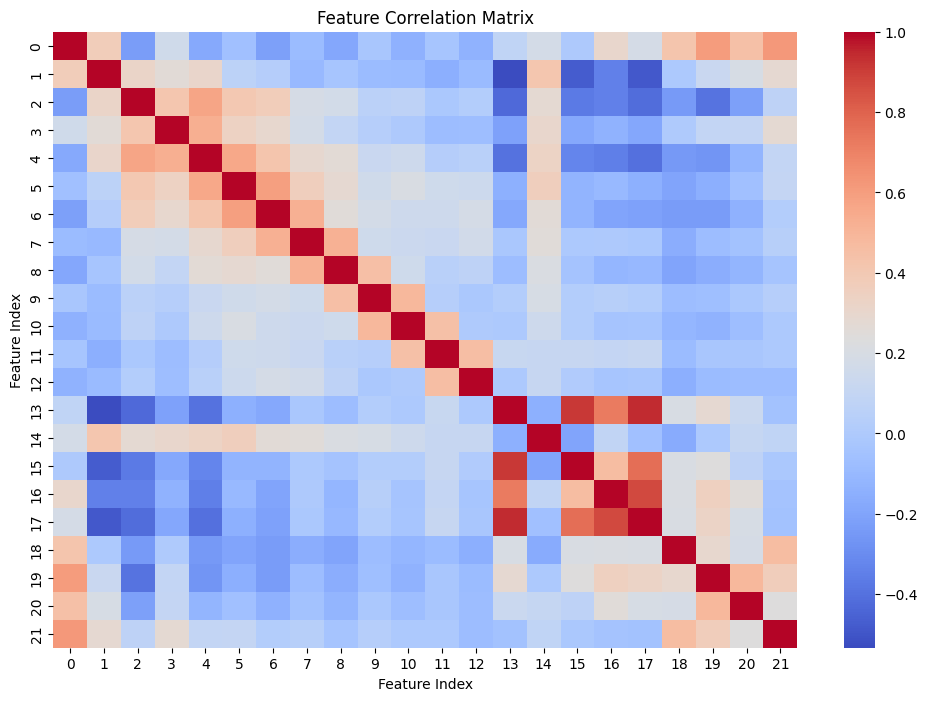

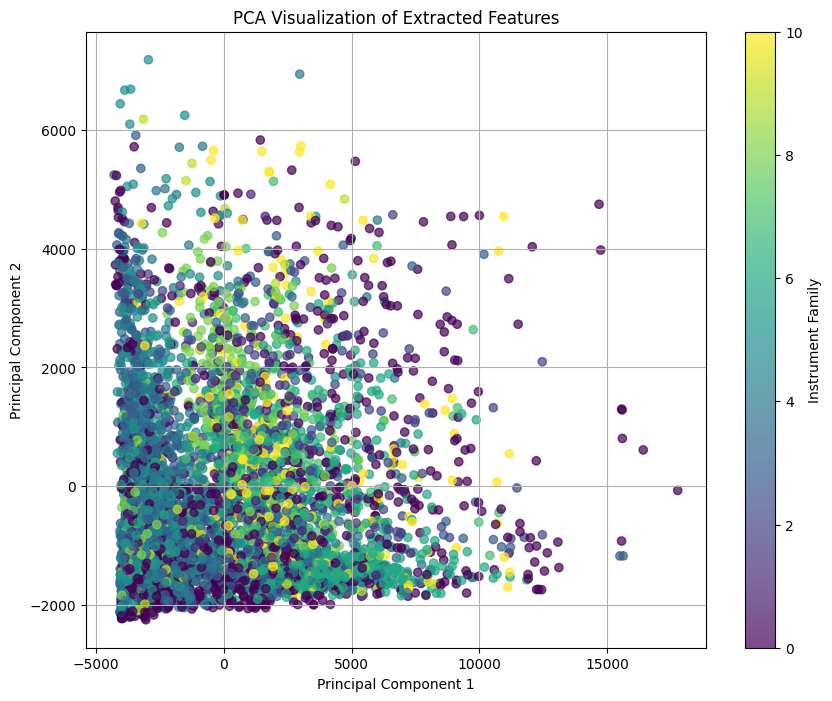

Explained Variance by Principal Components: [0.82652183 0.16477135]
Total Explained Variance: 0.99


In [24]:
%pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Step 1: Load Processed Features
data = pd.read_csv("processed_features.csv")

# Convert 'features' column to numerical arrays
data["features"] = data["features"].apply(eval)

# Extract features (X) and labels (y)
X = np.array(data["features"].tolist())  # Feature vectors
y = data["instrument_family"]            # Labels (instrument family)

# Step 2: Visualize Feature Correlations
# Compute pairwise correlation matrix
correlation_matrix = pd.DataFrame(X).corr()

# Plot the heatmap of feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()

# Step 3: PCA for Dimensionality Reduction
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Scatter plot of PCA components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Instrument Family")
plt.title("PCA Visualization of Extracted Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Step 4: Analyze Variance Contribution of PCA Components
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Principal Components: {explained_variance}")
print(f"Total Explained Variance: {sum(explained_variance):.2f}")


Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.76      0.69       249
           1       0.73      0.88      0.80        34
           2       0.85      0.52      0.64        33
           3       0.70      0.32      0.44       116
           4       0.54      0.73      0.62       178
           5       0.60      0.60      0.60       103
           6       0.82      0.78      0.79       120
           7       0.62      0.62      0.62        45
           8       0.82      0.73      0.77        67
           9       1.00      0.14      0.25        14
          10       0.92      0.54      0.68        41

    accuracy                           0.66      1000
   macro avg       0.75      0.60      0.63      1000
weighted avg       0.68      0.66      0.65      1000



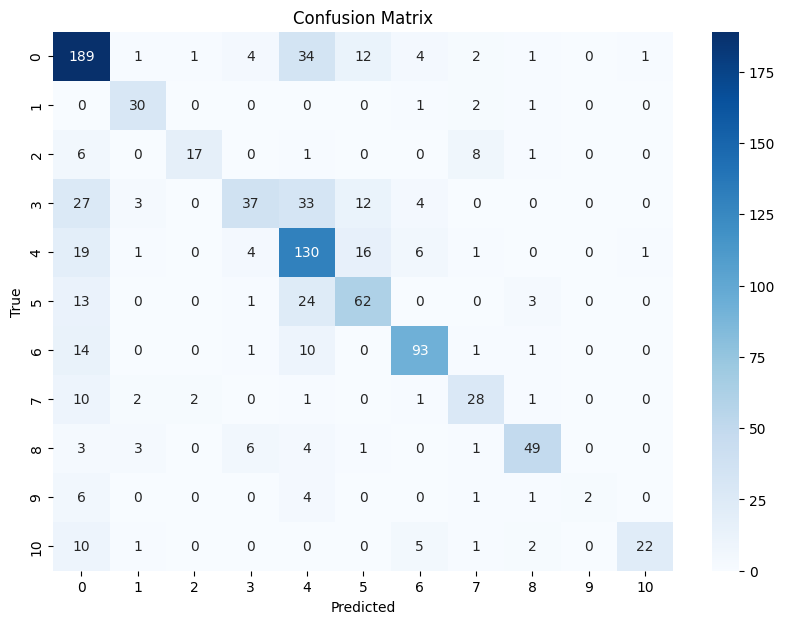

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

# Step 3: Evaluate the Model
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
